In [1]:
import numpy as np
import pandas as pd
import collections
import xlwings as xw
from scipy.sparse import vstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

def build_dataset(labels, FV):
    result = collections.Counter(labels)
    print(result)
    ratings = list(result.keys())
    counts = list(result.values())
    X_train = np.ones((1, FV.shape[1]))
    X_test = np.ones((1, FV.shape[1]))
    Y_train = np.ones((1,1))
    Y_test = np.ones((1,1))
    labels = labels.reshape(-1,1)
    arr_index = -1

    for i in range(0, len(counts)):
        num_train = int(counts[i]*2/3)
        num_test = counts[i] - num_train
        X_train = vstack([X_train, FV[arr_index+1:arr_index+num_train+1][:]]).toarray()
        Y_train = np.concatenate((Y_train, labels[arr_index+1:arr_index+num_train+1]), axis=0)
        arr_index += num_train
        X_test = vstack([X_test, FV[arr_index+1:arr_index+num_test+1][:]]).toarray()
        Y_test = np.concatenate((Y_test, labels[arr_index+1:arr_index+num_test+1]), axis=0)
        arr_index += num_test

    X_train = X_train[1:][:]
    X_test = X_test[1:][:]
    Y_train = Y_train[1:][:]
    Y_test = Y_test[1:][:]
    
    return X_train, X_test, Y_train, Y_test

corpus = list(pd.read_excel('train_set_2.xlsx')['Segement'].values)
# labels_1 = pd.read_excel('train_set_2.xlsx')['Label_1'].values # array type
labels_2 = pd.read_excel('train_set_2.xlsx')['Label_2'].values # array type

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
word = vectorizer.get_feature_names()
transformer = TfidfTransformer()

# get tfidf feature matrix
tfidf = transformer.fit_transform(X)

# get LIWC feature matrix and normalize
wb = xw.Book('train_set_2.xlsx')
sht = wb.sheets['dataset']
rng = sht.range('D2').expand('table')
arr_feature = np.asarray(rng.value)
scaler = MinMaxScaler()
scaler.fit(arr_feature)
LIWC = scaler.transform(arr_feature)

# build tfidf + 3 class dataset 
X_train1, X_test1, Y_train1, Y_test1 = build_dataset(labels_2, tfidf)

# build tfidf + regression dataset
# X_train2, X_test2, Y_train2, Y_test2 = build_dataset(labels_1, tfidf)

# build LIWC + 3 classes dataset 
X_train3, X_test3, Y_train3, Y_test3 = build_dataset(labels_2, LIWC)

# build LIWC + regression dataset 
# X_train4, X_test4, Y_train4, Y_test4 = build_dataset(labels_1, LIWC)

print(X_train1.shape)



Counter({1: 2095, 0: 2091, -1: 2032})
Counter({1: 2095, 0: 2091, -1: 2032})
(4144, 17967)


In [3]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression

# train model_1 -- tfidf + NB
clf1 = MultinomialNB()
clf1.fit(X_train1, Y_train1.flatten())

# train model_2 -- regression 
# reg1 = LinearRegression().fit(X_train2, Y_train2.flatten())

# train model_3 -- LIWC + NB
clf2 = MultinomialNB()
clf2.fit(X_train3, Y_train3.flatten())

# train model_4 -- LIWC + regression
# reg2 = LinearRegression().fit(X_train4, Y_train4.flatten())


def cal_conf(y_true, y_pred):
    return confusion_matrix(y_true, y_pred, labels=[-1, 0, 1])

MA1 = clf1.score(X_test1, Y_test1.flatten())
predicts1 = clf1.predict(X_test1)
conf1 = cal_conf(Y_test1, predicts1)
print('model_1 MA:', MA1)
print('model_1 conf:\n', conf1)

# MSE1 = mean_squared_error(Y_test2, reg1.predict(X_test2))
# print('\nmodel_2 MSE:', MSE1)

MA2 = clf2.score(X_test3, Y_test3.flatten())
predicts2 = clf2.predict(X_test3)
conf2 = cal_conf(Y_test3, predicts2)
print('\nmodel_3 MA:', MA2)
print('model_3 conf:\n', conf2)

# MSE2 = mean_squared_error(Y_test4, reg2.predict(X_test4))
# print('\nmodel_4 MSE:', MSE2)

model_1 MA: 0.8379942140790743
model_1 conf:
 [[537  83  58]
 [ 91 525  81]
 [  9  14 676]]

model_3 MA: 0.6779170684667309
model_3 conf:
 [[402 232  44]
 [113 526  58]
 [ 59 162 478]]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# construct different dimension reducation result by PCA
X1 = np.concatenate((X_train1, X_test1), axis=0)
Y1 = np.concatenate((Y_train1, Y_test1), axis=0)
n_features = min(X1.shape[0], X1.shape[1])
n_components = np.arange(100, n_features, 500)  # options for n_components

X1s = []
for n in n_components:
    svd = TruncatedSVD(n, n_iter=5)
    svd.fit(X1)
    X1_temp = svd.transform(X1)
    print('The shape for X1: ', X1_temp.shape)
    X1s.append([X1_temp, Y1.flatten()])


The shape for X1:  (6218, 100)


KeyboardInterrupt: 

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit

score = 'accuracy'
D = 'tfidf'
datasets = []

if D == 'tfidf':
    datasets = X1s
    C_range = np.logspace(-2, 2, 5)
    gamma_range = np.logspace(-2, 2, 5)
    cv = 5
else:
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
    C_range = np.logspace(-2, 5, 8)
    gamma_range = np.logspace(-5, 2, 8)
    X3 = np.concatenate((X_train3, X_test3), axis=0)
    Y3 = np.concatenate((Y_train3, Y_test3), axis=0)
    datasets.append([X3, Y3.flatten()])
    
tuned_parameters = [{'kernel': ['rbf'], 'gamma': gamma_range,
                     'C': C_range},
                    {'kernel': ['linear'], 'C': C_range}]
svd_svm_scores = []
svd_svm_params = []

# train for dataset 1 and 3
for dataset in datasets:
    print("# Tuning hyper-parameters for %s" % score)
    print()
    
    grid = GridSearchCV(SVC(), tuned_parameters, scoring=score, cv=cv, n_jobs=8, verbose=1)
    grid.fit(dataset[0], dataset[1])

    print("Best parameters set found on dataset {0}: ".format(dataset[0].shape))
    print()
    print(grid.best_params_)
    print()
    print("Grid scores on dataset:")
    print()
    means = grid.cv_results_['mean_test_score']
    stds = grid.cv_results_['std_test_score']
    svd_svm_scores.append(np.amax(means))
    svd_svm_params.append(grid.best_params_)
    for mean, std, params in zip(means, stds, grid.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

if D == 'tfidf':
    n_components_svd = n_components[np.argmax(svd_svm_scores)]
    params = svd_svm_params[np.argmax(svd_svm_scores)]
    acc = max(svd_svm_scores)
    print("best n_components by SVD CV = {0}, and its params = {1}, its acc. = {2}".format(n_components_svd, params, acc))

    plt.figure()
    plt.plot(n_components, svd_svm_scores, 'b', label='SVD scores')
    plt.axvline(n_components_svd, color='b',
                label='SVD CV: %d' % n_components_svd, linestyle='--')
    plt.xlabel('nb of components')
    plt.ylabel('CV scores')
    plt.legend(loc='lower right')
    plt.title('TFIDF SVD different dimensions cv scores for D2')
    plt.show()


# Tuning hyper-parameters for accuracy

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:   42.3s finished


Best parameters set found on dataset (6218, 100): 

{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on dataset:

0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.558 (+/-0.090) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.500 (+/-0.029) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.358 (+/-0.012) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.673 (+/-0.120) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.738 (+/-0.108) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.685 (+/-0.052) for {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
0.385 (+/-0.019) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.667 (+/-0.128) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.744 (+/-0.119) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.790 (+/-0.100) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.794 (+/-0.072) for {'C': 1.0, 'gamma': 10.0,

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed:  9.2min finished


Best parameters set found on dataset (6218, 600): 

{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on dataset:

0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.549 (+/-0.097) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.337 (+/-0.006) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.688 (+/-0.116) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.754 (+/-0.107) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.483 (+/-0.122) for {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
0.346 (+/-0.007) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.674 (+/-0.127) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.776 (+/-0.114) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.823 (+/-0.098) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.741 (+/-0.128) for {'C': 1.0, 'gamma': 10.0, 

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 19.3min finished


Best parameters set found on dataset (6218, 1100): 

{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on dataset:

0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.518 (+/-0.094) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.674 (+/-0.118) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.733 (+/-0.111) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.378 (+/-0.030) for {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
0.344 (+/-0.006) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.674 (+/-0.128) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.782 (+/-0.117) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.822 (+/-0.098) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.624 (+/-0.101) for {'C': 1.0, 'gamma': 10.0,

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  9.3min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 28.8min finished


Best parameters set found on dataset (6218, 1600): 

{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on dataset:

0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.510 (+/-0.109) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.674 (+/-0.119) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.713 (+/-0.110) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.371 (+/-0.028) for {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
0.344 (+/-0.006) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.674 (+/-0.130) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.780 (+/-0.118) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.822 (+/-0.100) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.589 (+/-0.098) for {'C': 1.0, 'gamma': 10.0,

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 14.0min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 46.5min finished


Best parameters set found on dataset (6218, 2100): 

{'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on dataset:

0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.520 (+/-0.130) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.670 (+/-0.118) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.694 (+/-0.110) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.368 (+/-0.027) for {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
0.345 (+/-0.007) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.674 (+/-0.128) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.778 (+/-0.116) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.823 (+/-0.096) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.584 (+/-0.097) for {'C': 1.0, 'gamma': 10.0,

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 18.2min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 55.7min finished


Best parameters set found on dataset (6218, 2600): 

{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on dataset:

0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.527 (+/-0.140) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.667 (+/-0.118) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.678 (+/-0.111) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.366 (+/-0.027) for {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
0.345 (+/-0.007) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.674 (+/-0.128) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.777 (+/-0.118) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.822 (+/-0.097) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.582 (+/-0.100) for {'C': 1.0, 'gamma': 10.0

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 21.0min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 63.3min finished


Best parameters set found on dataset (6218, 3100): 

{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on dataset:

0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}
0.533 (+/-0.147) for {'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.01, 'gamma': 100.0, 'kernel': 'rbf'}
0.337 (+/-0.000) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.664 (+/-0.117) for {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
0.663 (+/-0.111) for {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}
0.365 (+/-0.026) for {'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}
0.345 (+/-0.007) for {'C': 0.1, 'gamma': 100.0, 'kernel': 'rbf'}
0.674 (+/-0.128) for {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}
0.775 (+/-0.116) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.823 (+/-0.102) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.567 (+/-0.094) for {'C': 1.0, 'gamma': 10.0

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [6]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit

cv = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
score = 'accuracy'
C_range = np.logspace(0, 1, 2)
gamma_range = np.logspace(-1, 0, 2)

tuned_parameters = [{'kernel': ['rbf'], 'gamma': gamma_range,
                     'C': C_range},
                    {'kernel': ['linear'], 'C': C_range}]

print("# Tuning hyper-parameters for %s" % score)
print()

grid = GridSearchCV(SVC(), tuned_parameters, scoring=score, cv=cv, n_jobs=16, verbose=1)
grid.fit(X1, Y1.flatten())

print("Best parameters set found on dataset {0}: ".format(dataset[0].shape))
print()
print(grid.best_params_)
print()
print("Grid scores on dataset:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
full_max = np.amax(means)
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

# Tuning hyper-parameters for accuracy

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed: 55.6min
[Parallel(n_jobs=16)]: Done  60 out of  60 | elapsed: 107.2min finished


NameError: name 'dataset' is not defined

In [7]:
print("Best parameters set found on dataset {0}: ".format(X1.shape))
print()
print(grid.best_params_)
print()
print("Grid scores on dataset:")
print()
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
full_max = np.amax(means)
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

Best parameters set found on dataset (6218, 17967): 

{'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}

Grid scores on dataset:

0.782 (+/-0.017) for {'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.838 (+/-0.017) for {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.836 (+/-0.015) for {'C': 10.0, 'gamma': 0.1, 'kernel': 'rbf'}
0.840 (+/-0.017) for {'C': 10.0, 'gamma': 1.0, 'kernel': 'rbf'}
0.837 (+/-0.018) for {'C': 1.0, 'kernel': 'linear'}
0.819 (+/-0.016) for {'C': 10.0, 'kernel': 'linear'}



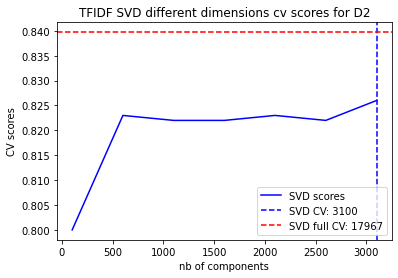

In [9]:
svd_svm_scores = [0.800, 0.823, 0.822, 0.822, 0.823, 0.822, 0.826]

n_components_svd = n_components[np.argmax(svd_svm_scores)]
# params = svd_svm_params[np.argmax(svd_svm_scores)]
acc = max(svd_svm_scores)
# print("best n_components by SVD CV = {0}, and its params = {1}, its acc. = {2}".format(n_components_svd, params, acc))

plt.figure()
plt.plot(n_components[:7], svd_svm_scores, 'b', label='SVD scores')
plt.axvline(n_components_svd, color='b',
            label='SVD CV: %d' % n_components_svd, linestyle='--')
plt.axhline(full_max, color='r',
            label='SVD full CV: %d' % X1.shape[1], linestyle='--')
plt.xlabel('nb of components')
plt.ylabel('CV scores')
plt.legend(loc='lower right')
plt.title('TFIDF SVD different dimensions cv scores for D2')
plt.show()